In [34]:
from pathlib import Path

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

from plot_functions import bar_plot, distribution_plot, line_plot_variables, violin_plot

## SETUP

In [35]:
# prompt version (currently only working with 2.0, but nice to be able to easily change)
version = 3.0

In [36]:
metrics_dir = Path.cwd().parents[0] / "metrics"

plots_dir = Path.cwd().parents[0] / "plots" / f"v{version}"

curves_dir = plots_dir / "curves"
barplots_dir = plots_dir / "barplots"
postags_dir = plots_dir / "postags"

for dir in [curves_dir, barplots_dir, postags_dir]:
    dir.mkdir(parents=True, exist_ok=True)

In [ ]:
# for giving shorter names in df 
model_dict = {
    "mlx-community--Qwen2.5-7B-Instruct-1M-4bit": "Qwen 2.5 7B Instruct 1M (4bit)",
    "mlx-community--meta-Llama-3.1-8B-Instruct-4bit": "Llama 3.1 8B Instruct (4bit)",
    "meta-llama--Llama-3.1-8B-Instruct": "Llama 3.1 8B Instruct",
    "Qwen--Qwen2.5-7B-Instruct": "Qwen 2.5 7B Instruct",
    "mistralai--Mistral-7B-Instruct-v0.3": "Mistral 7B Instruct v0.3",
}

SyntaxError: ':' expected after dictionary key (3799946022.py, line 7)

## Text Stats

### Load and Process

In [ ]:
group_levels = pl.Enum(["A1", "B1", "C1"])
text_stats_df = pl.read_csv(metrics_dir / f"v{version}_text_stats.csv", schema_overrides={"group": group_levels}) 

In [ ]:
text_stats_df = text_stats_df.with_columns(pl.col("model").replace_strict(model_dict))

### Plot

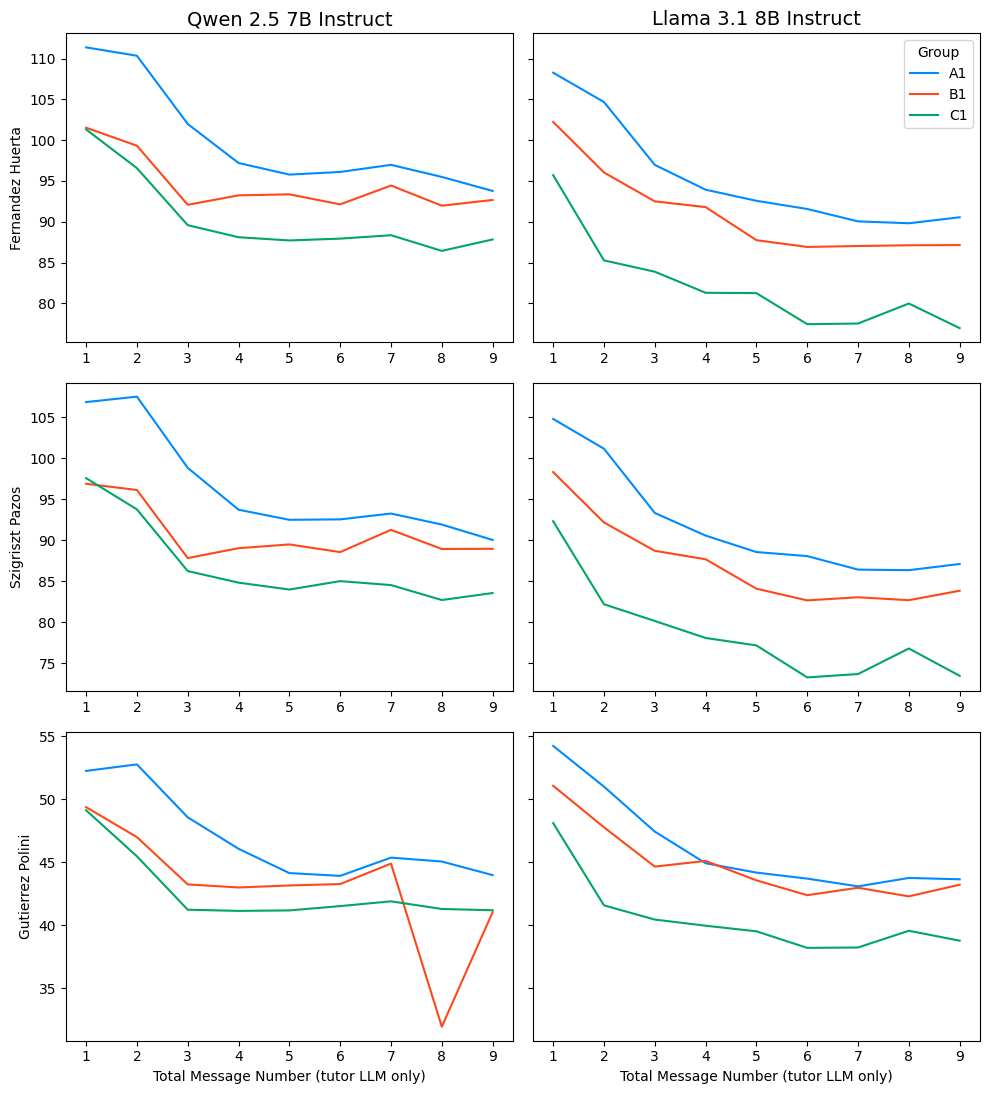

In [ ]:
role = "assistant"
filtered_text_stats_df = text_stats_df.filter(pl.col("role") == role)

# assign message numbers
filtered_text_stats_df = filtered_text_stats_df.with_columns(total_message_number=pl.int_range(1, pl.len() + 1).over("id"))

# compute average scores
avg_df = filtered_text_stats_df.group_by(["model", "group", "total_message_number"], maintain_order=True).mean()

# variables to plot
vars = ["fernandez_huerta", "szigriszt_pazos", "gutierrez_polini"]

colors = ["#008aff", "#ff471a", "#00a661"]

fig = line_plot_variables(df=avg_df, 
                    x_var="total_message_number", 
                    y_vars=vars, 
                    group_var="group",
                    model_var="model", 
                    x_label_text="Total Message Number (tutor LLM only)", 
                    group_colors=colors)

fig.savefig(plots_dir / "curves" / "spanish_readability_high_easy.png", dpi=300)

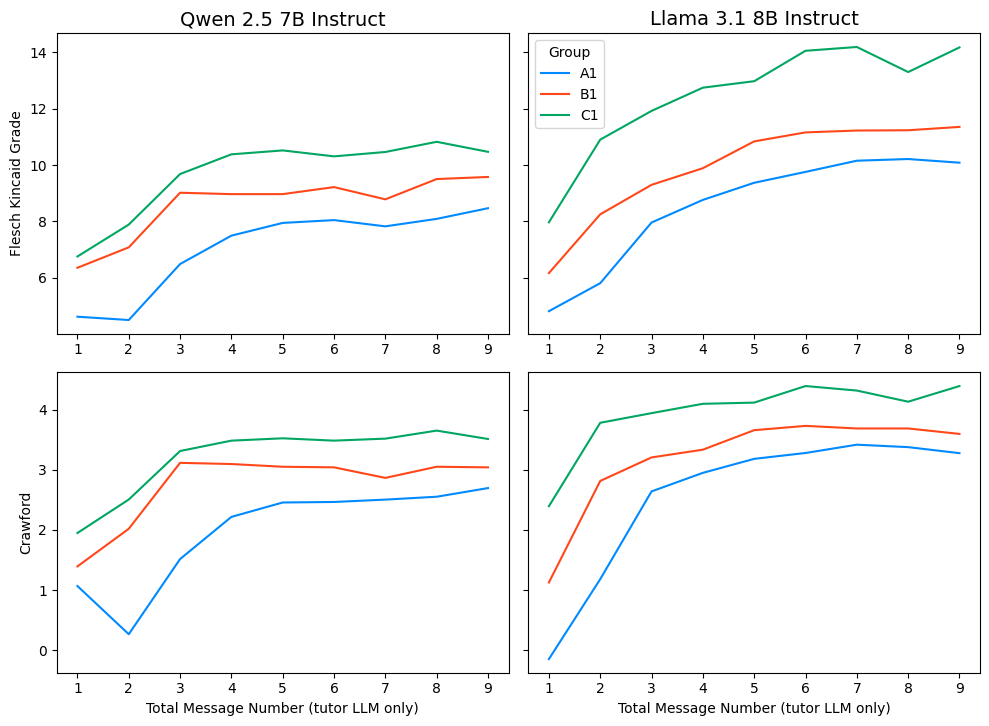

In [ ]:
colors = ["#008aff", "#ff471a", "#00a661"]

fig = line_plot_variables(df=avg_df, 
                    x_var="total_message_number", 
                    y_vars=["flesch_kincaid_grade", "crawford"], 
                    group_var="group",
                    model_var="model", 
                    x_label_text="Total Message Number (tutor LLM only)", 
                    group_colors=colors)

fig.savefig(plots_dir / "curves" / "spanish_readability_high_difficult.png", dpi=300)

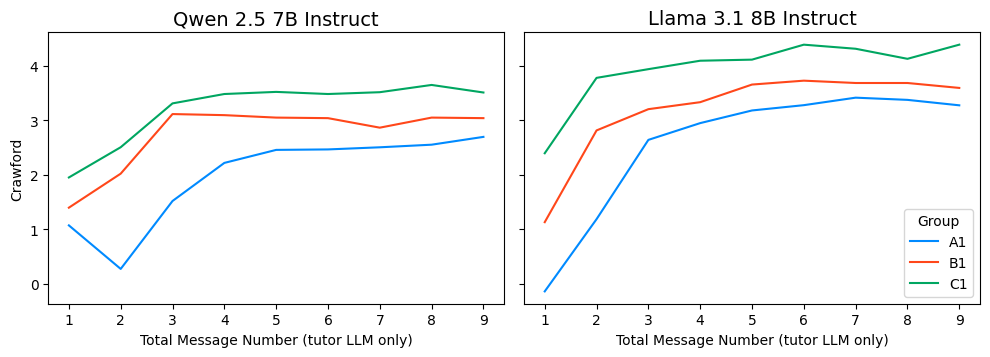

In [ ]:
colors = ["#008aff", "#ff471a", "#00a661"]

fig = line_plot_variables(df=avg_df, 
                    x_var="total_message_number", 
                    y_vars=["crawford"], 
                    group_var="group",
                    model_var="model", 
                    x_label_text="Total Message Number (tutor LLM only)", 
                    group_colors=colors)

fig.savefig(plots_dir / "curves" / "crawford.png", dpi=300)

## Text Descriptives

In [ ]:
group_levels = pl.Enum(["A1", "B1", "C1"])

td_df = pl.read_csv(metrics_dir / f"v{version}_textdescriptives.csv", schema_overrides={"group": group_levels}) 

td_df = td_df.with_columns(pl.col("model").replace_strict(model_dict))

In [ ]:
role = "assistant"
filtered_td_df = td_df.filter(pl.col("role") == role)
# assign message numbers
filtered_td_df = filtered_td_df.with_columns(total_message_number=pl.int_range(1, pl.len() + 1).over("id"))

## Doc Length

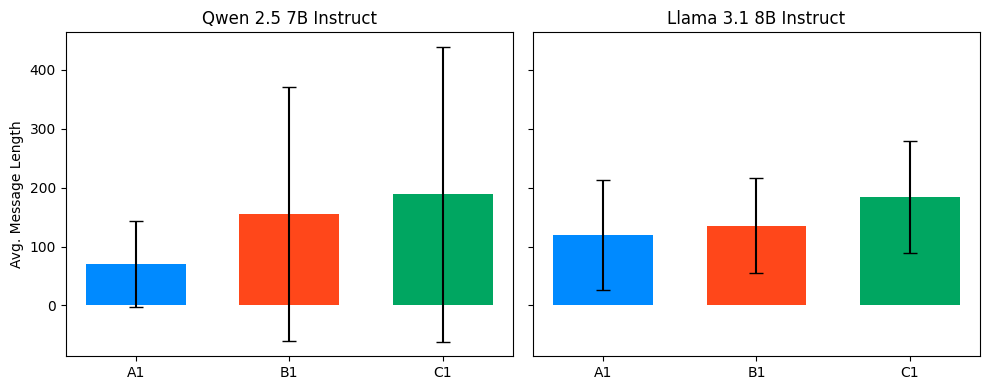

In [ ]:
avg_df = (
    filtered_td_df
    .group_by(["model", "group"], maintain_order=True)
    .agg([
        pl.col("doc_length").mean().alias("mean_doc_length"),
        pl.col("doc_length").std().alias("std_doc_length"),
    ])
)

fig = bar_plot(avg_df, 
                x_vars=["mean_doc_length"],
                std_vars = ["std_doc_length"], 
                y_label_texts=["Avg. Message Length"])

fig.savefig(plots_dir / "barplots" /  "avg_message_length.png", dpi=300)

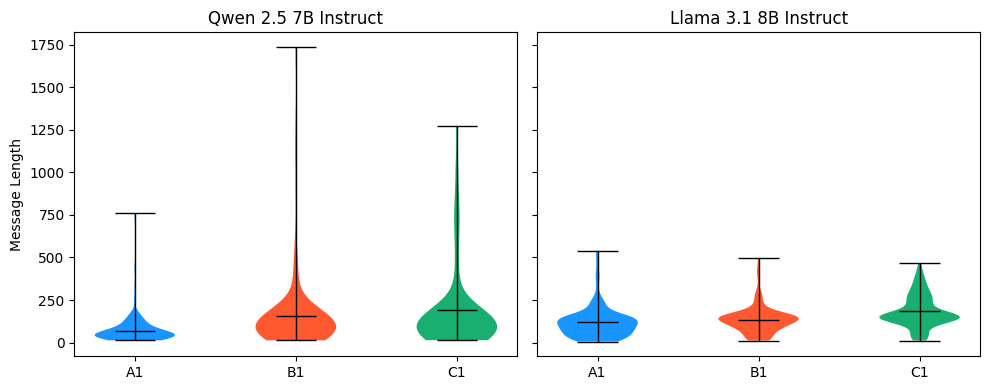

In [ ]:
fig = violin_plot(
    filtered_td_df,  # Use the full dataset
    x_vars=["doc_length"],  # Pass raw values instead of mean
    group_var="group",
    model_var="model",
    y_label_texts=["Message Length"]
)

fig.savefig(plots_dir / "message_length_violin.png", dpi=300)

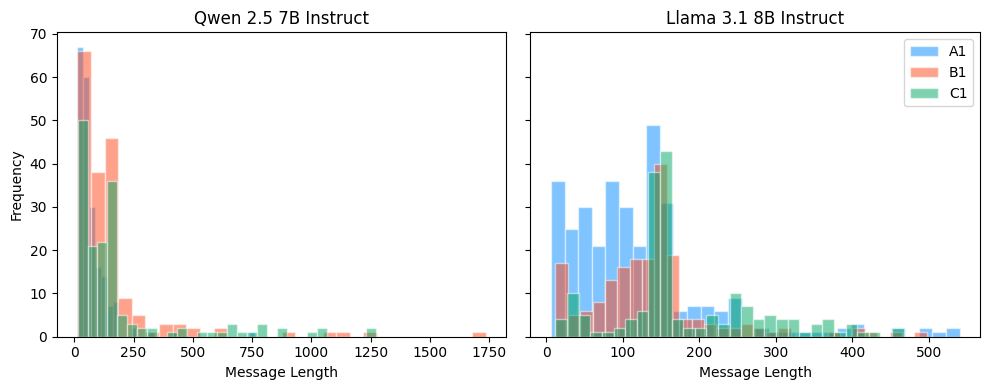

In [ ]:
fig = distribution_plot(filtered_td_df, x_vars=["doc_length"], normalize=False, alpha=0.5, x_label_texts=["Message Length"])

fig.savefig(plots_dir / "message_length_dist.png", dpi=300)

### Unique Tokens

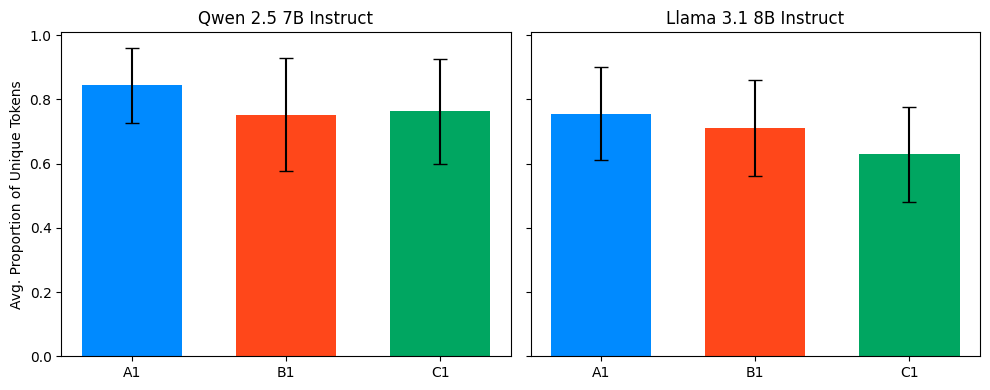

In [ ]:
avg_df = (
    filtered_td_df
    .group_by(["model", "group"], maintain_order=True)
    .agg([
        pl.col("proportion_unique_tokens").mean().alias("mean_proportion_unique_tokens"),
        pl.col("proportion_unique_tokens").std().alias("std_proportion_unique_tokens")
    ])
)

fig = bar_plot(avg_df, 
                x_vars=["mean_proportion_unique_tokens"],
                std_vars = ["std_proportion_unique_tokens"], 
                y_label_texts=["Avg. Proportion of Unique Tokens"])

fig.savefig(plots_dir / "barplots" / "avg_proportion_of_unique_tokens.png", dpi=300)

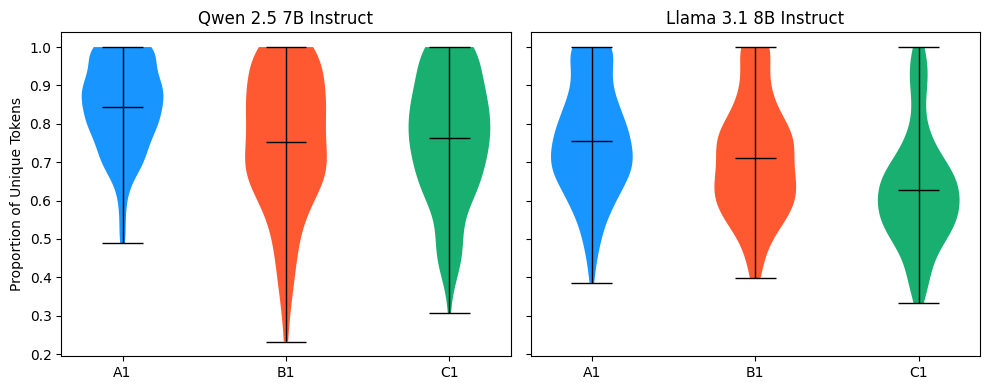

In [ ]:
fig = violin_plot(
    filtered_td_df,  # Use the full dataset
    x_vars=["proportion_unique_tokens"], 
    group_var="group",
    model_var="model",
    y_label_texts=["Proportion of Unique Tokens"]
)

fig.savefig(plots_dir / "unique_tokens_violin.png", dpi=300)

## Length and Unique Tokens over conversation length

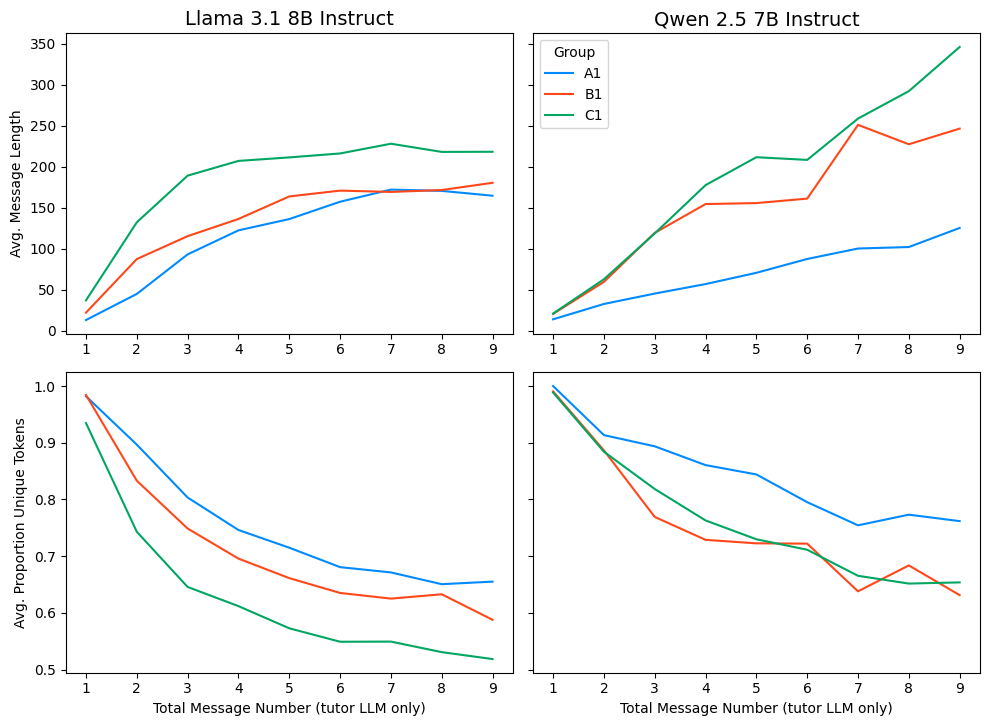

In [ ]:
avg_df = (
    filtered_td_df
    .group_by(["model", "group", "total_message_number"], maintain_order=True)
    .agg([
        pl.col("doc_length").mean().alias("avg._message_length"),
        pl.col("proportion_unique_tokens").mean().alias("avg._proportion_unique_tokens"),
    ])
)

fig = line_plot_variables(df=avg_df, 
                    x_var="total_message_number", 
                    y_vars=["avg._message_length", "avg._proportion_unique_tokens"], 
                    group_var="group",
                    model_var="model", 
                    x_label_text="Total Message Number (tutor LLM only)", 
                    group_colors=colors)

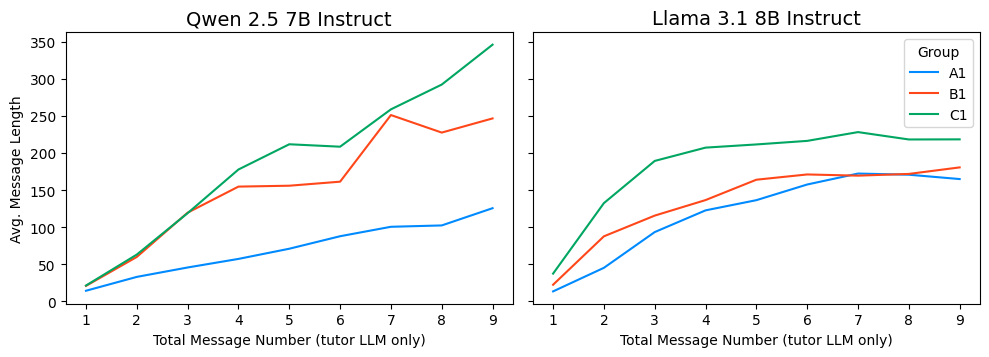

In [ ]:
fig = line_plot_variables(df=avg_df, 
                    x_var="total_message_number", 
                    y_vars=["avg._message_length"],
                    group_var="group",
                    model_var="model", 
                    x_label_text="Total Message Number (tutor LLM only)", 
                    group_colors=colors)

fig.savefig(plots_dir / "curves" / "avg_message_length.png", dpi=300)

### Parts of Speech Tagging

In [ ]:
def generate_custom_colors(n_colors):
    base_colors = ["#008aff", "#ff471a", "#00a661"]
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", base_colors)
    return [cmap(i / (n_colors - 1)) for i in range(n_colors)]

def plot_group_overview(df, group_col, model_col, model_name, variables, 
                        y_label_text=None, main_title=None):
    df_model = df.filter(pl.col(model_col) == model_name)
    avg_df = df_model.group_by(group_col, maintain_order=True).mean()
    groups = avg_df[group_col].unique().to_list()

    num_vars = len(variables)
    fig, axes = plt.subplots(1, len(groups), figsize=(5 * len(groups), 4), sharey=True)

    if len(groups) == 1:
        axes = [axes]

    # Generate custom colors
    colors = generate_custom_colors(num_vars)

    for ax, group in zip(axes, groups):
        group_data = avg_df.filter(pl.col(group_col) == group)
        proportions = [group_data[var][0] for var in variables]

        x = np.arange(len(variables))
        ax.bar(x, proportions, color=colors)

        ax.set_xticks(x)
        ax.set_xticklabels(variables, rotation=45, ha="right")
        ax.set_title(f"{group}")
        
        if y_label_text: 
            ax.set_ylabel(y_label_text)
    
    if main_title: 
        fig.suptitle(main_title)

    plt.tight_layout()

    return fig

In [ ]:
pos_props = [
    "pos_prop_ADJ", "pos_prop_ADP", "pos_prop_ADV", "pos_prop_AUX",
    "pos_prop_CCONJ", "pos_prop_DET", "pos_prop_INTJ", "pos_prop_NOUN",
    "pos_prop_NUM", "pos_prop_PART", "pos_prop_PRON", "pos_prop_PROPN",
    "pos_prop_PUNCT", "pos_prop_SCONJ", "pos_prop_SYM", "pos_prop_VERB",
] # https://universaldependencies.org/u/pos/

rename_mapping = {col: col.replace("pos_prop_", "") for col in pos_props}
new_pos_props_names = list(rename_mapping.values())
filtered_td_df = filtered_td_df.rename(rename_mapping)

In [ ]:
model_1 = list(model_dict.values())[0]
plot = plot_group_overview(filtered_td_df, group_col="group", model_col = "model", model_name=model_1, variables=new_pos_props_names, y_label_text = "Proportion", main_title=model_1)

plot.savefig(plots_dir / "postags" / "qwen_pos.png", dpi=300)

ValueError: Number of columns must be a positive integer, not 0

<Figure size 0x400 with 0 Axes>

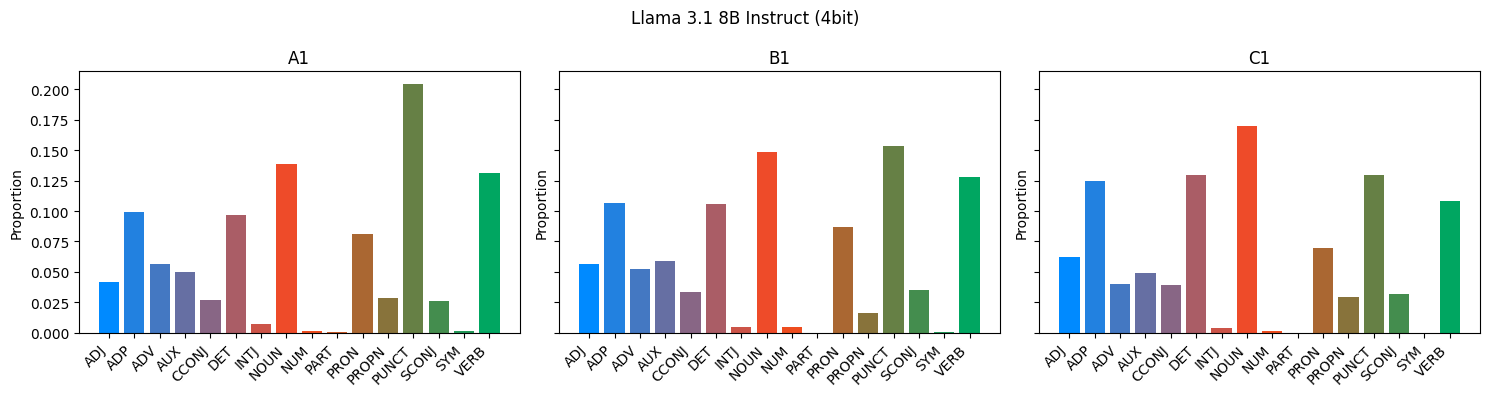

In [ ]:
model_1 = list(model_dict.values())[1]
plot = plot_group_overview(filtered_td_df, group_col="group", model_col = "model", model_name=model_1, variables=new_pos_props_names, y_label_text = "Proportion", main_title=model_1)

plot.savefig(plots_dir / "postags" / "llama_pos.png", dpi=300)